In [1]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:
def process_dataarray(da_o3):
    if da_o3.name != 'O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR':
        da_transposed = da_o3.transpose('time', 'altitude')
        
        n_time = da_transposed.sizes['time']
        n_alt = da_transposed.sizes['altitude']
        
        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_transposed.data, da.Array):
            da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
        else:
            da_transposed.data = da.from_array(da_transposed.data,
                                            chunks=(time_chunks, alt_chunks))
        return da_transposed
    else:
        n_time = da_o3.sizes['DATETIME']
        n_alt = da_o3.sizes['altitude1']

        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'DATETIME': time_chunks, 'altitude1': alt_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data,
                                            chunks=(time_chunks, alt_chunks))
        return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [3]:
import OSIRIS.OSIRIS_helper as OSIRIS
import PEARL_FTIR.PEARL_FTIR_helper as PEARL

In [4]:
daO = OSIRIS.get_vmr()
daP = PEARL.get_vmr()

In [5]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_GRID = daP["altitude1"].values
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [6]:
daO = daO.interp({"altitude": ALT_GRID})
daP = daP.interp({"altitude1": ALT_GRID})

# ALT_MIN, ALT_MAX = 
# daO = daO
# daP = daP

daO = process_dataarray(daO)
daP = process_dataarray(daP)

In [7]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)

In [8]:
o3O_arr = daO.values.astype(np.float32)
latO = daO.latitude.values
lonO = daO.longitude.values
tO = daO.time.values.astype('datetime64[ns]')

o3P_arr = daP.values.astype(np.float32)
tP = daP.DATETIME.values.astype('datetime64[ns]')
num_P_data = len(tP)
latP = np.array([PEARL.latitude] * num_P_data)
lonP = np.array([PEARL.longitude] * num_P_data)

tP_min = tP.min() - TIME_TOL
tP_max = tP.max() + TIME_TOL
time_mask = (tO >= tP_min) & (tO <= tP_max)
tO_filtered = tO[time_mask]
o3O_arr_filtered = o3O_arr[time_mask]
latO_filtered = latO[time_mask]
lonO_filtered = lonO[time_mask]

client.close()
cluster.close()
del o3O_arr, latO, lonO
gc.collect()

63442

In [9]:
tO_ns = tO_filtered.astype(np.int64)
tP_ns = tP.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

n_alt = len(ALT_GRID)
MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3P_coincidences = []
o3O_coincidences = []
measurement_times = []
measurement_times_dt = []

time_bins = np.arange(tO_ns.min(), tO_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tO_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tP_ns, latP, lonP)):
    if s_idx % 10000 == 0:
        print(f"Processing PEARL FTIR point {s_idx}/{len(tP)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tO_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latO_filtered[time_valid_indices]
    candidate_lons = lonO_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3O_coincidences.append(o3O_arr_filtered[best_L_idx])
        o3P_coincidences.append(o3P_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at PEARL FTIR point {s_idx}...")

        measurement_times.append(tP_ns[s_idx])
        measurement_times_dt.append(tP[s_idx])

o3P_coincidences = np.vstack(o3P_coincidences)
o3O_coincidences = np.vstack(o3O_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing PEARL FTIR point 0/6261...
Found 1000 pairs at PEARL FTIR point 1327...
Found 2000 pairs at PEARL FTIR point 2966...
Found 3000 pairs at PEARL FTIR point 4533...
Total coincidences found: 3617


In [10]:
seasonal_months = {"DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11]}

pd_measurement_times = pd.to_datetime(measurement_times_dt)
seasonal_measurement_idx = {season: np.where(pd_measurement_times.month.isin(months))[0]
                            for season, months in seasonal_months.items()}

In [11]:
o3P_seasonal_coincidences = {season: o3P_coincidences[seasonal_measurement_idx[season]]
                             for season in seasonal_measurement_idx}

o3O_seasonal_coincidences = {season: o3O_coincidences[seasonal_measurement_idx[season]]
                             for season in seasonal_measurement_idx}

o3P_seasonal_coincidences_times = {season: np.array(measurement_times)[seasonal_measurement_idx[season]]
                                   for season in seasonal_measurement_idx}

n_seasonal_coincidences = {season: o3P_seasonal_coincidences[season].shape[0]
                           for season in o3P_seasonal_coincidences}

no_seasonal_coincidences = [season for season, n in n_seasonal_coincidences.items() if n == 0]

In [12]:
max_time = max(measurement_times)
min_time = min(measurement_times)

vmin = np.percentile(measurement_times, 2.5)
vmax = np.percentile(measurement_times, 97.5)

vmin = max(vmin - 0.025 * (vmax - vmin), min_time)
vmax = min(vmax + 0.025 * (vmax-vmin), max_time)

normalizer = plt.Normalize(vmin=vmin, vmax=vmax, clip=True)

num_ticks = 7
tick_locations = np.linspace(vmin, vmax, num=num_ticks)
tick_dates = tick_locations.astype('datetime64[ns]')
tick_labels = list(np.datetime_as_string(tick_dates, unit='D'))
               
cmap = plt.get_cmap('nipy_spectral')
mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)

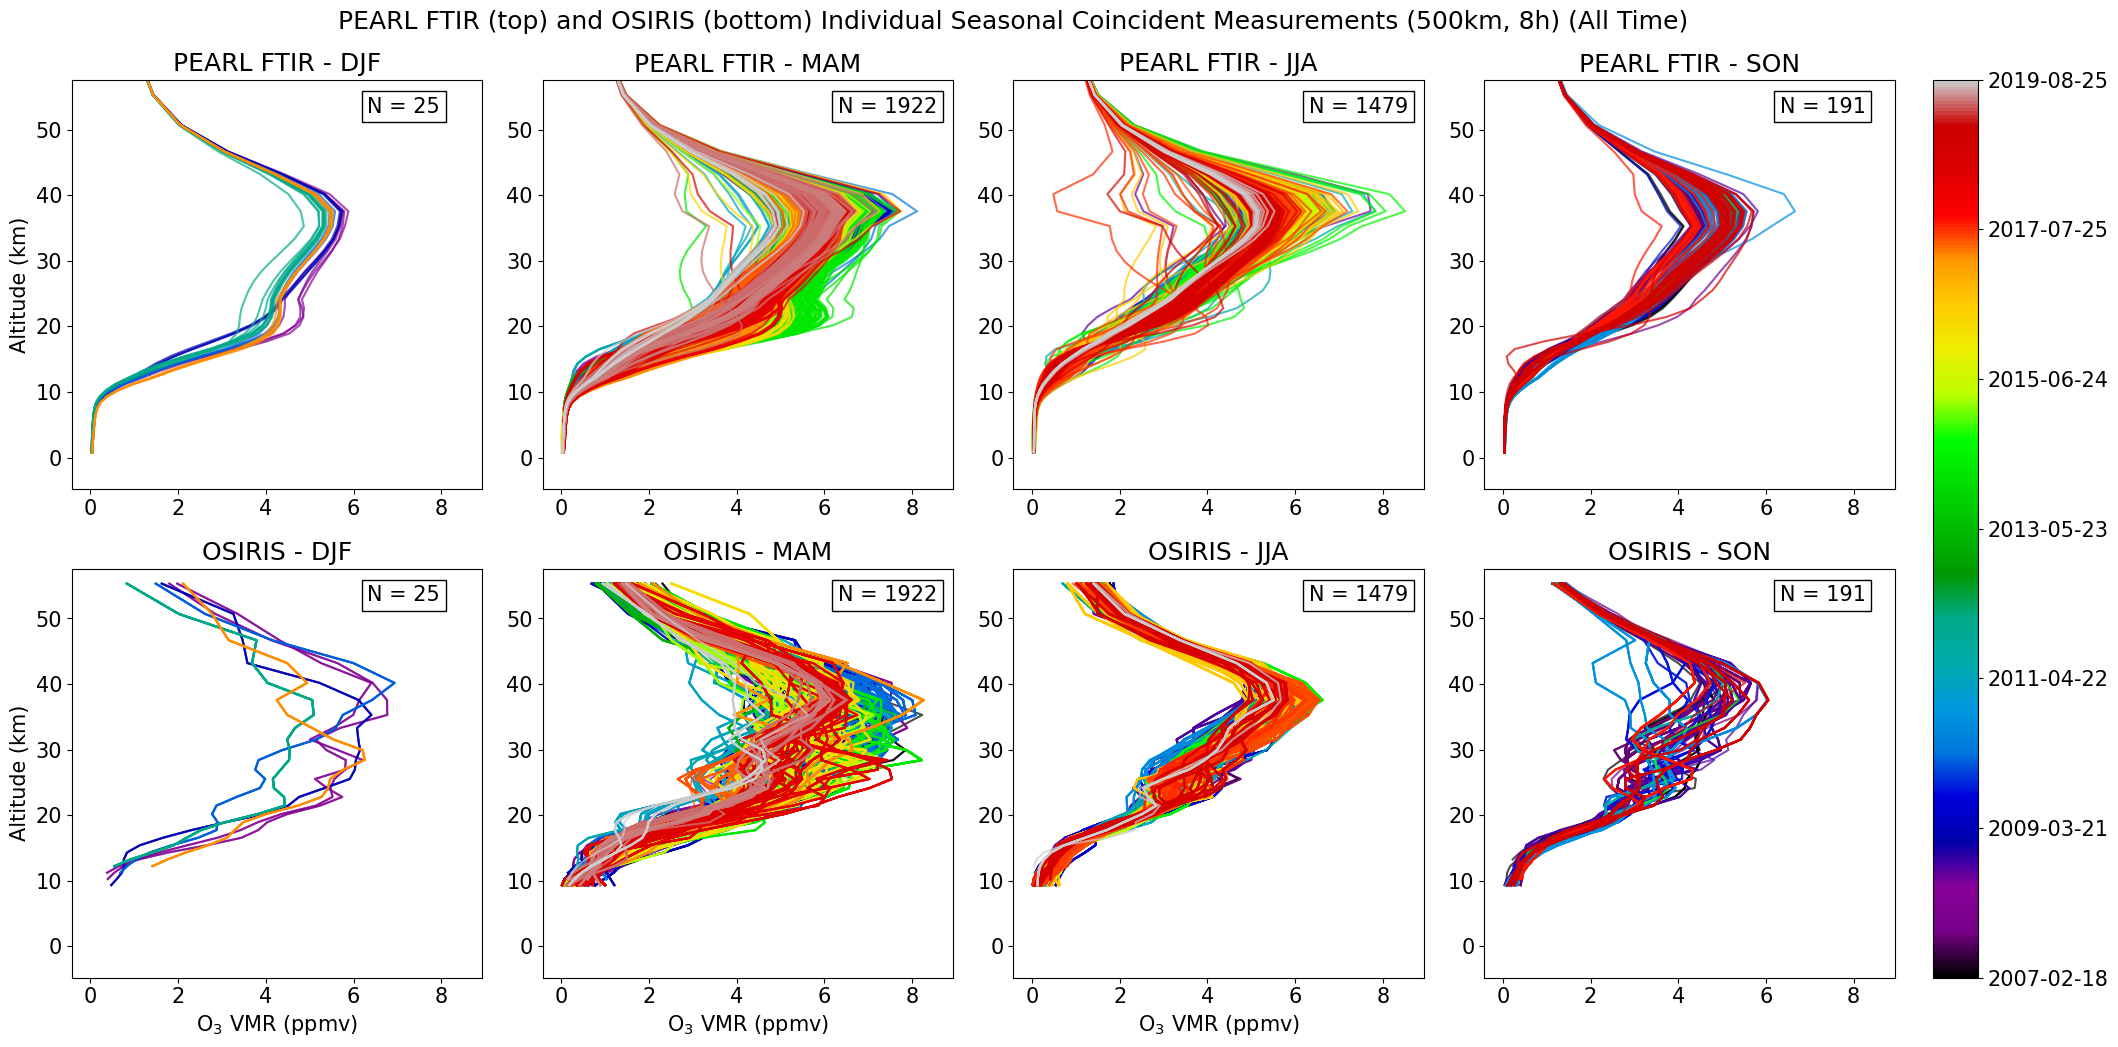

In [13]:
fig, axes = plt.subplots(2, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

xmins = []
xmaxs = []
ymins = []
ymaxs = []

for i, season in enumerate(seasons):
    top_ax = axes[0, i]
    bottom_ax = axes[1, i]
    season_times = o3P_seasonal_coincidences_times[season]
    n_season_coincidences = n_seasonal_coincidences[season]

    for j, o3P_season_coincidence in enumerate(o3P_seasonal_coincidences[season]):
        P_values = o3P_seasonal_coincidences[season][j, :] * 10**6
        
        color = cmap(normalizer(season_times[j]))

        top_ax.plot(
            P_values,
            ALT_GRID,
            color=color,
            alpha=0.7
        )
        top_ax.set_title(f"PEARL FTIR - {season}")

    
        O_values = o3O_seasonal_coincidences[season][j, :] * 10**6
        
        bottom_ax.plot( 
            O_values,
            ALT_GRID,
            color=color,
            alpha=0.7
        )
        bottom_ax.set_title(f"OSIRIS - {season}")
    
    top_ax.text(0.720, 0.920, f"N = {n_season_coincidences}", fontsize=15, transform=top_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
    bottom_ax.text(0.720, 0.920, f"N = {n_season_coincidences}", fontsize=15, transform=bottom_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

    bottom_ymin, bottom_ymax = bottom_ax.get_ylim()
    top_ymin, top_ymax = top_ax.get_ylim()

    bottom_xmin, bottom_xmax = bottom_ax.get_xlim()
    top_xmin, top_xmax = top_ax.get_xlim()

    xmins.append(bottom_xmin)
    xmins.append(top_xmin)
    xmaxs.append(bottom_xmax)
    xmaxs.append(top_xmax)

    ymins.append(bottom_ymin)
    ymins.append(top_ymin)
    ymaxs.append(bottom_ymax)
    ymaxs.append(top_ymax)

min_xlim, max_xlim = min(xmins), max(xmaxs)
min_ylim, max_ylim = min(ymins), min(ymaxs)

for ax in axes.flat:
    ax.set_xlim(min_xlim, max_xlim)
    ax.set_ylim(min_ylim, max_ylim)

fig.tight_layout()

cbar = fig.colorbar(
    mappable,
    ax = axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02)

cbar.set_ticks(tick_locations)
cbar.ax.set_yticklabels(tick_labels)

axes[1, 0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1, 1].set_xlabel("O$_3$ VMR (ppmv)")
axes[1, 2].set_xlabel("O$_3$ VMR (ppmv)")
axes[0, 0].set_ylabel("Altitude (km)")
axes[1, 0].set_ylabel("Altitude (km)")

plt.suptitle("PEARL FTIR (top) and OSIRIS (bottom) Individual Seasonal Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

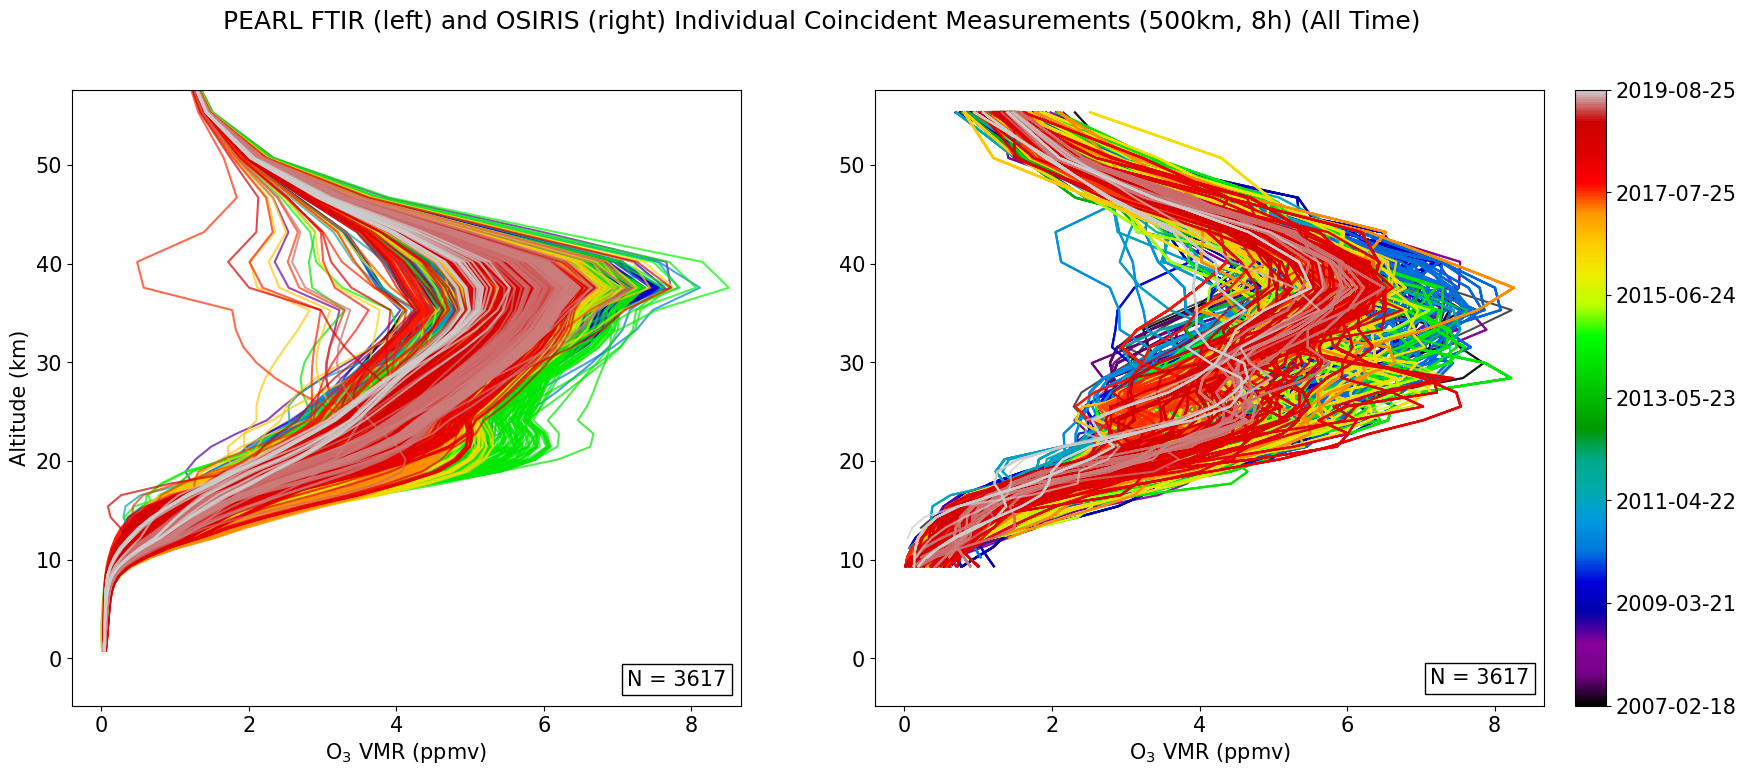

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

n_coincidences = o3P_coincidences.shape[0]
mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)

for coincidence_idx in range(n_coincidences):
    P_values = o3P_coincidences[coincidence_idx, :] * 10**6
    
    O_values = o3O_coincidences[coincidence_idx, :] * 10**6
    
    color = cmap(normalizer(measurement_times[coincidence_idx]))
    axes[0].plot(
        P_values,
        ALT_GRID,
        color=color,
        alpha=0.7
    )
    
    axes[1].plot(
        O_values,
        ALT_GRID,
        color=color,
        alpha=0.7
    )

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")

cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
)

cbar.set_ticks(tick_locations)
cbar.ax.set_yticklabels(tick_labels)

ax1_ymin, ax1_ymax = axes[1].get_ylim()
ax0_ymin, ax0_ymax = axes[0].get_ylim()

axes[0].set_xlim(axes[1].get_xlim())
axes[0].set_ylim(ax0_ymin, ax1_ymax)
axes[1].set_ylim(ax0_ymin, ax1_ymax)

plt.suptitle("PEARL FTIR (left) and OSIRIS (right) Individual Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)")

axes[0].text(0.830, 0.0325, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes[0].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
axes[1].text(0.830, 0.035, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes[1].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [15]:
rel, abs = compute_diffs(o3O_coincidences, o3P_coincidences)

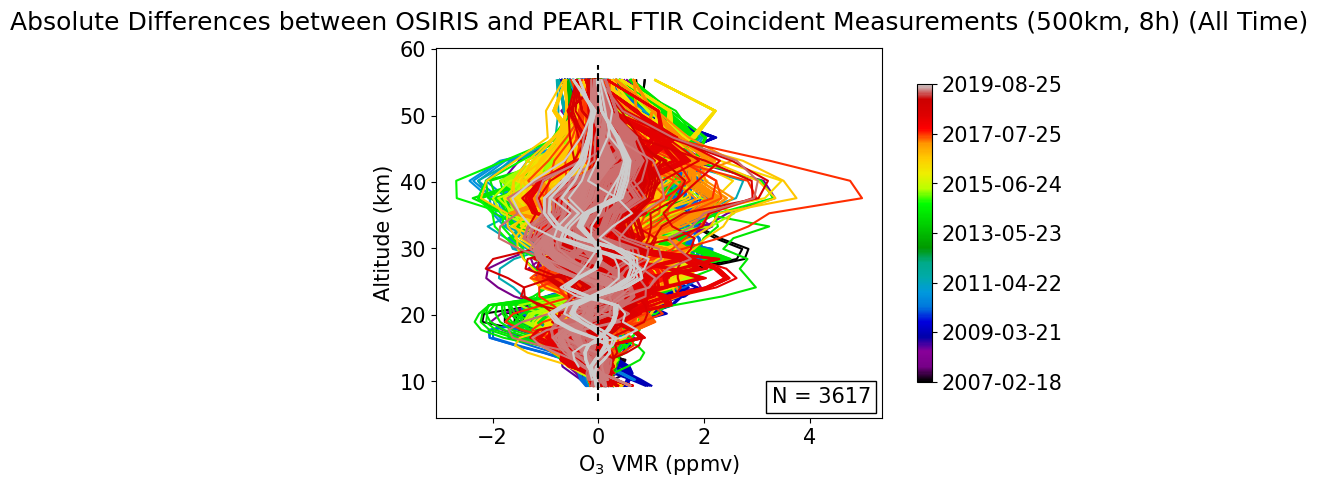

In [16]:
for i in range(n_coincidences):
    plt.plot(abs[i,:] * 10**6, ALT_GRID, color = cmap(normalizer(measurement_times[i])))

mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", y = 1.03)

fig = plt.gcf()
axes = plt.gca()

cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.07
)

cbar.set_ticks(tick_locations)
cbar.ax.set_yticklabels(tick_labels)

axes.text(0.752, 0.040, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [17]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)

C:\Users\salla\AppData\Local\Temp\ipykernel_23132\3706030345.py:1: RuntimeWarning: Mean of empty slice
  rel_diffs = np.nanmean(rel, axis = 0)
c:\Users\salla\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\salla\AppData\Local\Temp\ipykernel_23132\3706030345.py:4: RuntimeWarning: Mean of empty slice
  abs_diffs = np.nanmean(abs, axis = 0)


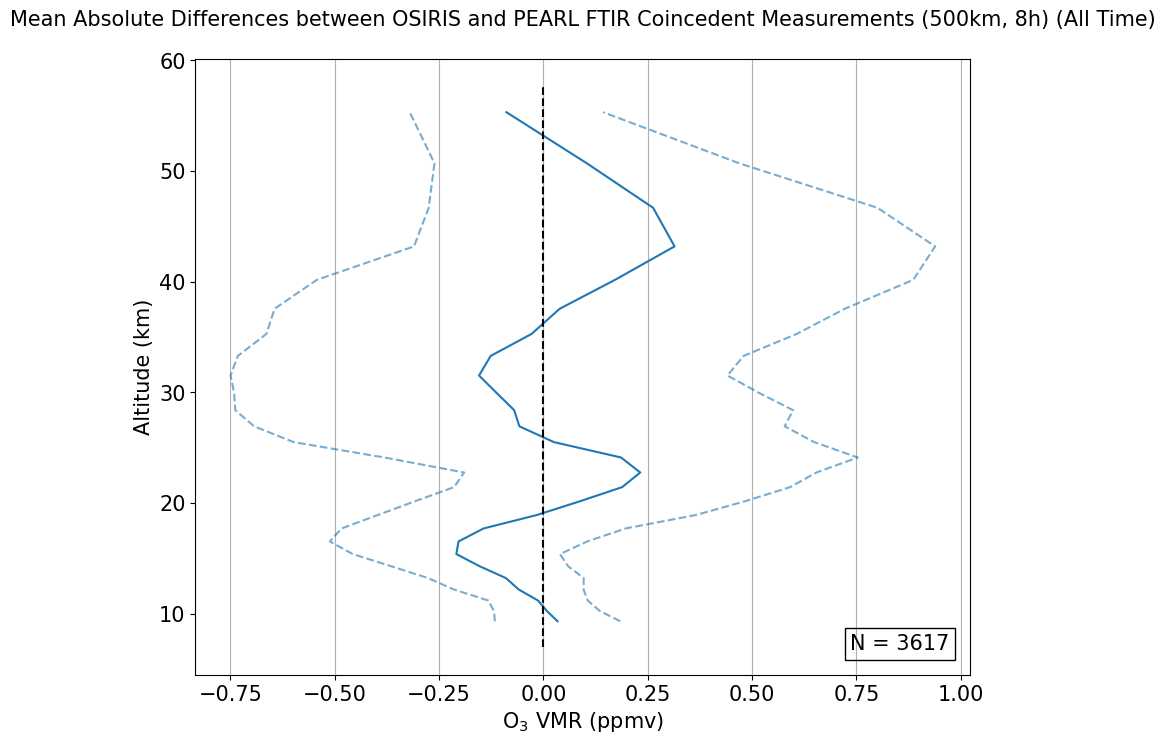

In [18]:
plt.figure(figsize=(10,8))
plt.plot(abs_diffs * 10**6, ALT_GRID)
plt.plot((abs_diffs * 10**6) + (abs_std * 10**6), ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot((abs_diffs * 10**6) - (abs_std * 10**6), ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean Absolute Differences between OSIRIS and PEARL FTIR Coincedent Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {'fontsize': 15}, y = 1.04)

fig = plt.gcf()
axes = plt.gca()

axes.grid(axis = "x")
axes.text(0.845, 0.040, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

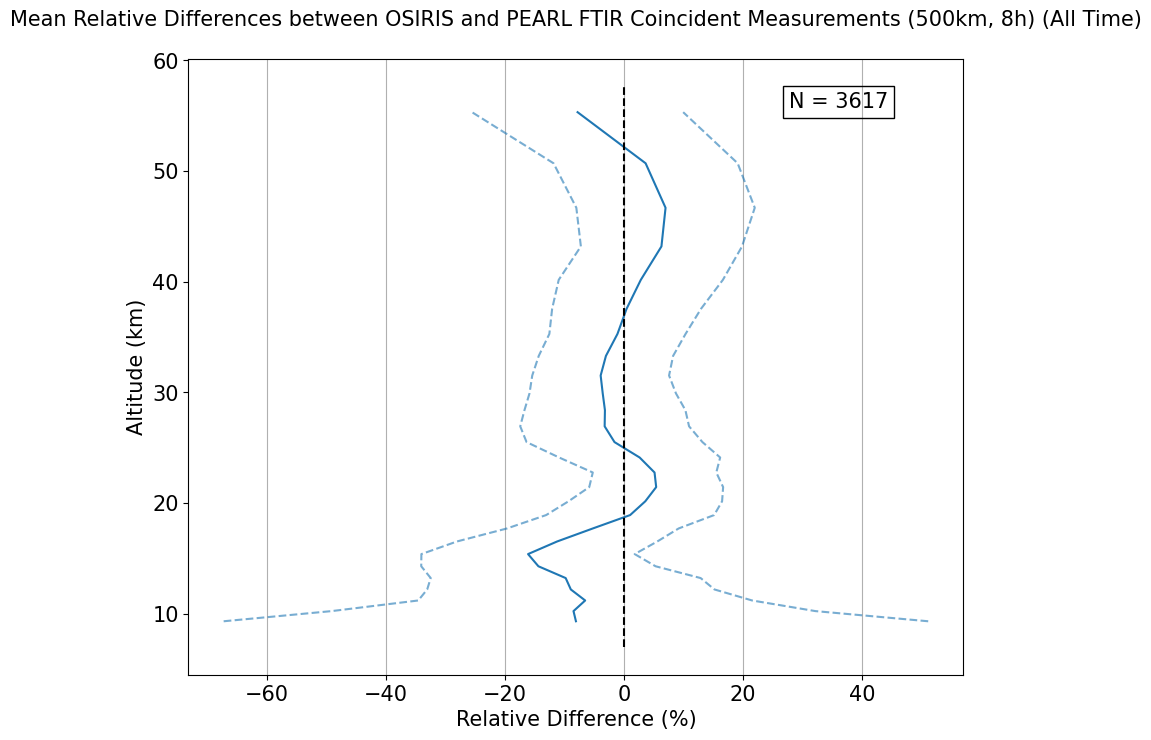

In [19]:
plt.figure(figsize=(10,8))
plt.plot(rel_diffs, ALT_GRID)
plt.plot(rel_diffs - rel_std, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot(rel_diffs + rel_std, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Mean Relative Differences between OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {'fontsize': 15}, y = 1.04)

fig = plt.gcf()
axes = plt.gca()

axes.grid(axis = "x")
axes.text(0.775, 0.920, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

In [20]:
rel_seasonal = {season: compute_diffs(o3O_seasonal_coincidences[season], o3P_seasonal_coincidences[season])[0] for season in seasonal_months}

abs_seasonal = {season: compute_diffs(o3O_seasonal_coincidences[season], o3P_seasonal_coincidences[season])[1] for season in seasonal_months}

rel_diffs_seasonal = {season: np.nanmean(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

rel_std_seasonal = {season: np.nanstd(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

abs_diffs_seasonal = {season: np.nanmean(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

abs_std_seasonal = {season: np.nanstd(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

C:\Users\salla\AppData\Local\Temp\ipykernel_23132\86752624.py:5: RuntimeWarning: Mean of empty slice
  rel_diffs_seasonal = {season: np.nanmean(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}
C:\Users\salla\AppData\Local\Temp\ipykernel_23132\86752624.py:9: RuntimeWarning: Mean of empty slice
  abs_diffs_seasonal = {season: np.nanmean(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}


-104.50872344970703 62.703005981445315
4.5040620517730705 60.14318717002868


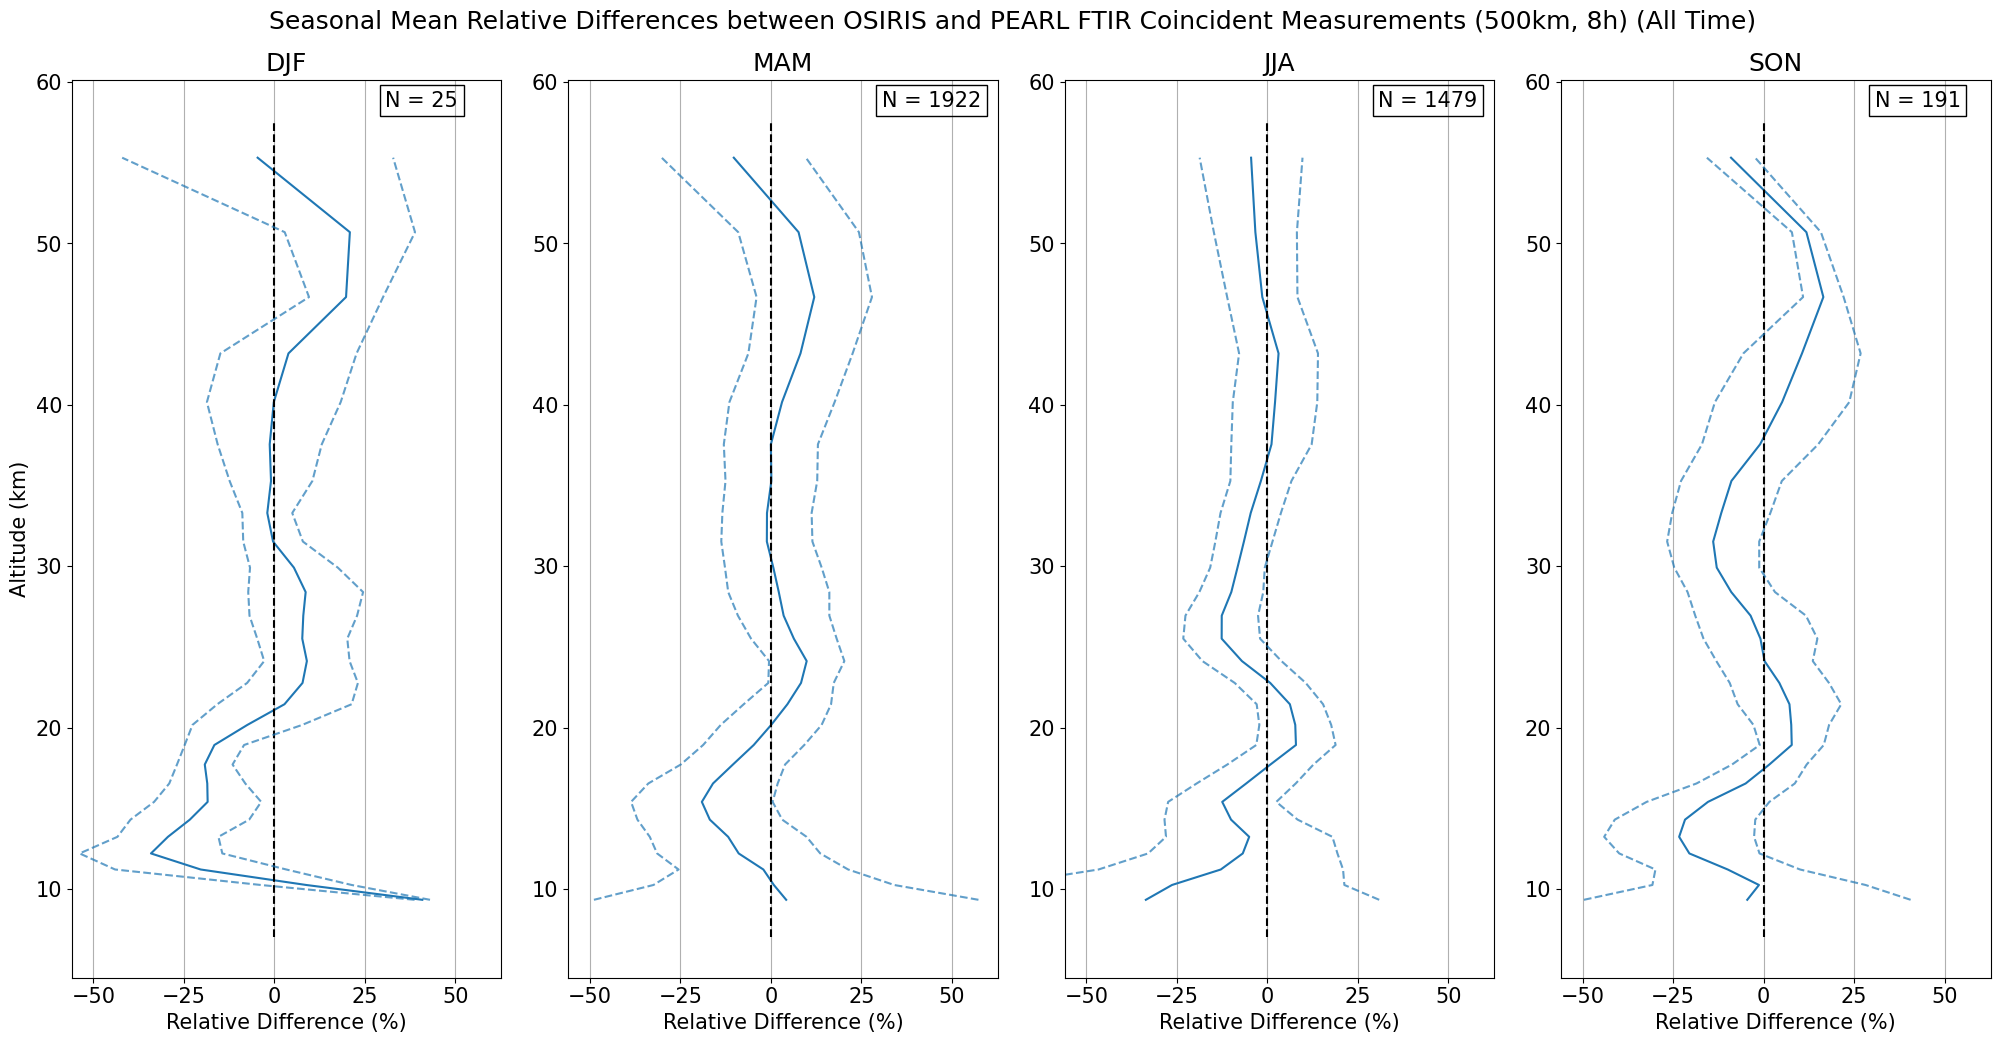

In [34]:
fig, axes = plt.subplots(1, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

xmins = []
xmaxs = []
ymins = []
ymaxs = []

for i, season in enumerate(seasons):
    top_ax = axes[i]
    n_season_coincidences = n_seasonal_coincidences[season]

    top_ax.plot(
        rel_diffs_seasonal[season],
        ALT_GRID
    )
    top_ax.set_title(f"{season}")
    
    top_ax.plot([0, 0], list(top_ax.get_ylim()), color = "black", linestyle = "--")

    top_ax.plot(
        rel_diffs_seasonal[season] - rel_std_seasonal[season],
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.plot(
        rel_diffs_seasonal[season] + rel_std_seasonal[season],
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.grid(axis = "x")
    top_ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([i for i in range(-100,101,25)]))

    top_ax.text(0.730, 0.970, f"N = {n_season_coincidences}", fontsize=15, transform=top_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

    top_ymin, top_ymax = top_ax.get_ylim()

    top_xmin, top_xmax = top_ax.get_xlim()

    xmins.append(top_xmin)
    xmaxs.append(top_xmax)

    ymins.append(top_ymin)
    ymaxs.append(top_ymax)

min_xlim, max_xlim = min(xmins), max(xmaxs)
min_ylim, max_ylim = min(ymins), min(ymaxs)

for ax in axes.flat:
    ax.set_xlim(-56, max_xlim)
    ax.set_ylim(min_ylim, max_ylim)

print(min_xlim, max_xlim)
print(min_ylim, max_ylim)

    
fig.tight_layout()




axes[0].set_xlabel("Relative Difference (%)")
axes[1].set_xlabel("Relative Difference (%)")
axes[2].set_xlabel("Relative Difference (%)")
axes[3].set_xlabel("Relative Difference (%)")

axes[0].set_ylabel("Altitude (km)")

plt.suptitle("Seasonal Mean Relative Differences between OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

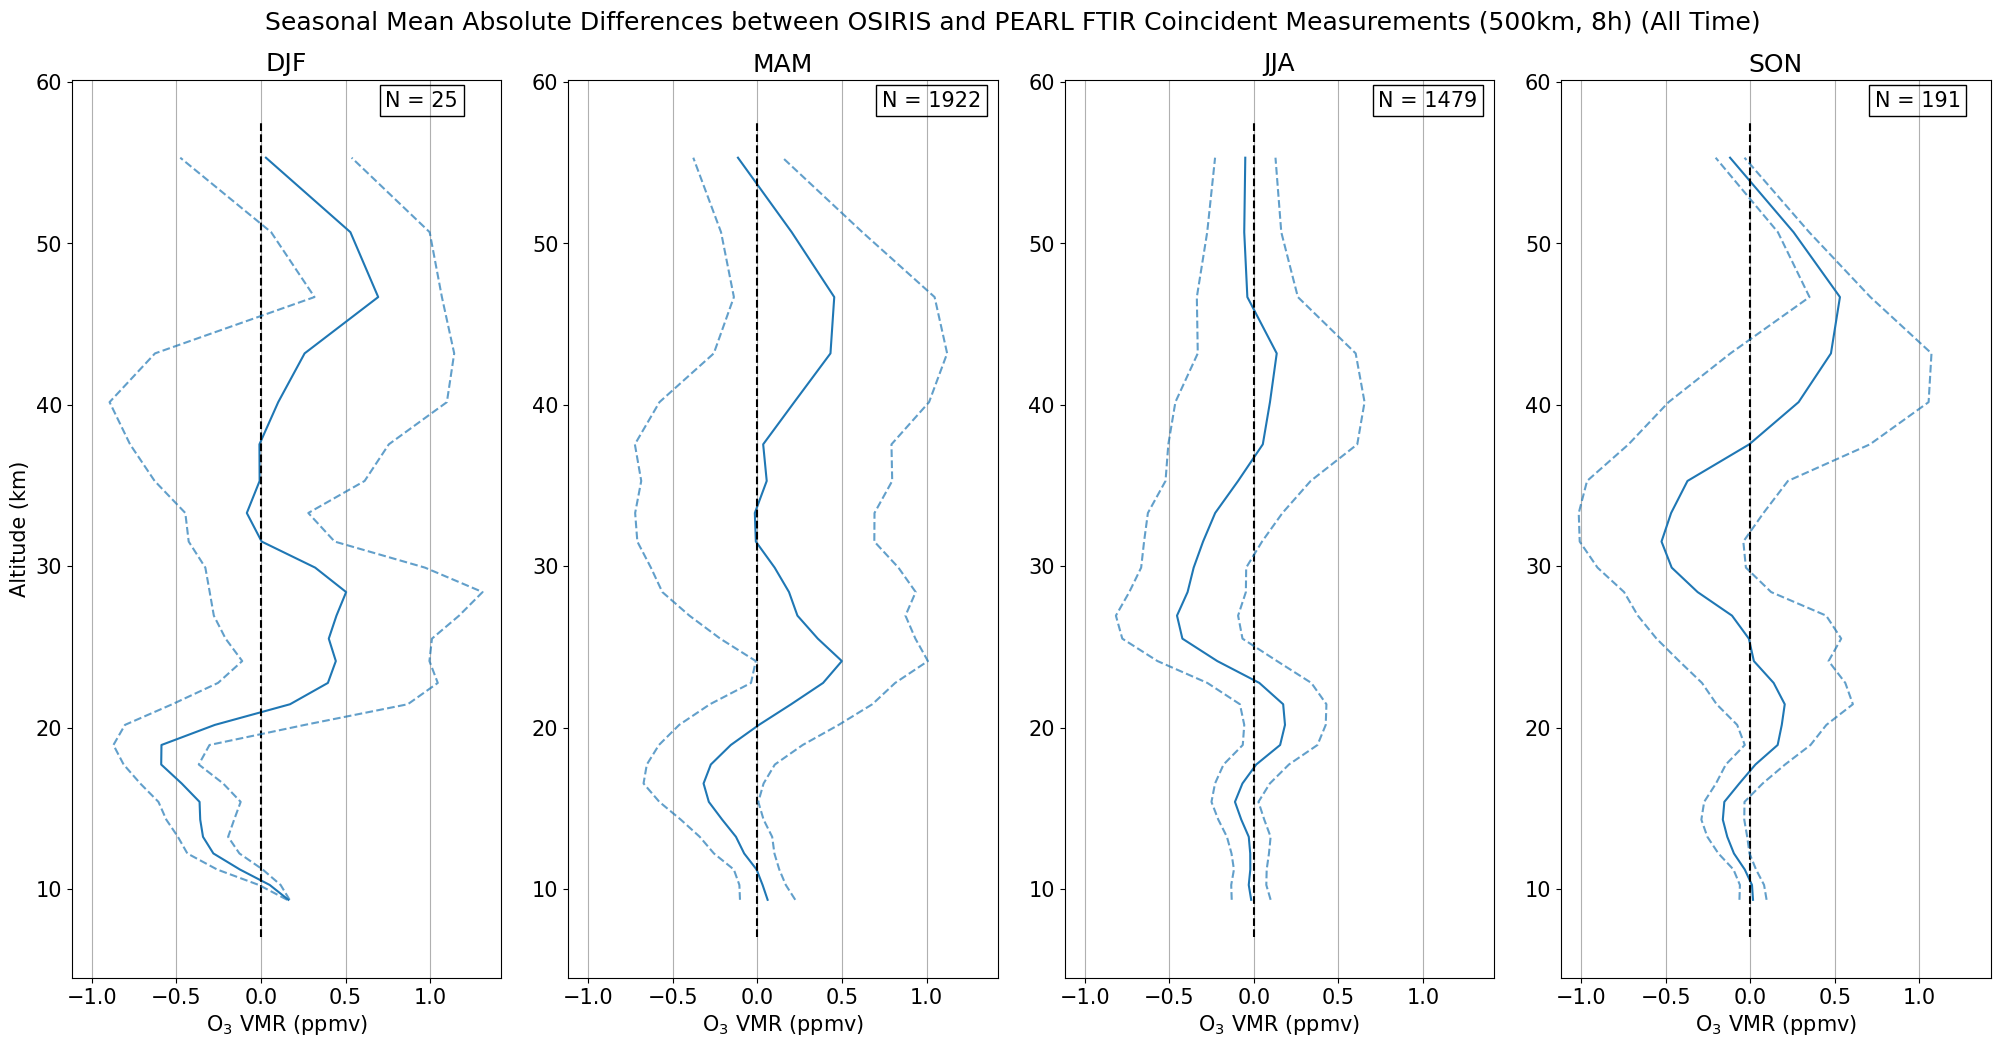

In [22]:
fig, axes = plt.subplots(1, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

xmins = []
xmaxs = []
ymins = []
ymaxs = []

for i, season in enumerate(seasons):
    top_ax = axes[i]
    n_season_coincidences = n_seasonal_coincidences[season]

    top_ax.plot(
        (abs_diffs_seasonal[season]) * 10**6,
        ALT_GRID
    )
    top_ax.set_title(f"{season}")
    
    top_ax.plot([0, 0], list(top_ax.get_ylim()), color = "black", linestyle = "--")

    top_ax.plot(
        (abs_diffs_seasonal[season] - abs_std_seasonal[season]) * 10**6,
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.plot(
        (abs_diffs_seasonal[season] + abs_std_seasonal[season]) * 10**6,
        ALT_GRID,
        alpha=0.7,
        color = "C0",
        linestyle = "dashed"
    )

    top_ax.text(0.730, 0.970, f"N = {n_season_coincidences}", fontsize=15, transform=top_ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

    top_ax.grid(axis = "x")

    top_ymin, top_ymax = top_ax.get_ylim()

    top_xmin, top_xmax = top_ax.get_xlim()

    xmins.append(top_xmin)
    xmaxs.append(top_xmax)

    ymins.append(top_ymin)
    ymaxs.append(top_ymax)

min_xlim, max_xlim = min(xmins), max(xmaxs)
min_ylim, max_ylim = min(ymins), min(ymaxs)

for ax in axes.flat:
    ax.set_xlim(min_xlim, max_xlim)
    ax.set_ylim(min_ylim, max_ylim)
    
fig.tight_layout()

for ax in axes:
    ax.set_xlabel("O$_3$ VMR (ppmv)")

axes[0].set_ylabel("Altitude (km)")

plt.suptitle("Seasonal Mean Absolute Differences between OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [23]:
std_O_seasonal = {
    season: np.nanstd(coincidence, axis = 0, ddof = 1)
    for season, coincidence in o3O_seasonal_coincidences.items()
}
std_P_seasonal = {
    season: np.nanstd(coincidence, axis = 0, ddof = 1)
    for season, coincidence in o3P_seasonal_coincidences.items()
}
mean_O_seasonal = {
    season: np.nanmean(coincidence, axis = 0)
    for season, coincidence in o3O_seasonal_coincidences.items()
}
mean_P_seasonal = {
    season: np.nanmean(coincidence, axis = 0)
    for season, coincidence in o3P_seasonal_coincidences.items()
}

C:\Users\salla\AppData\Local\Temp\ipykernel_23132\1964385615.py:10: RuntimeWarning: Mean of empty slice
  season: np.nanmean(coincidence, axis = 0)


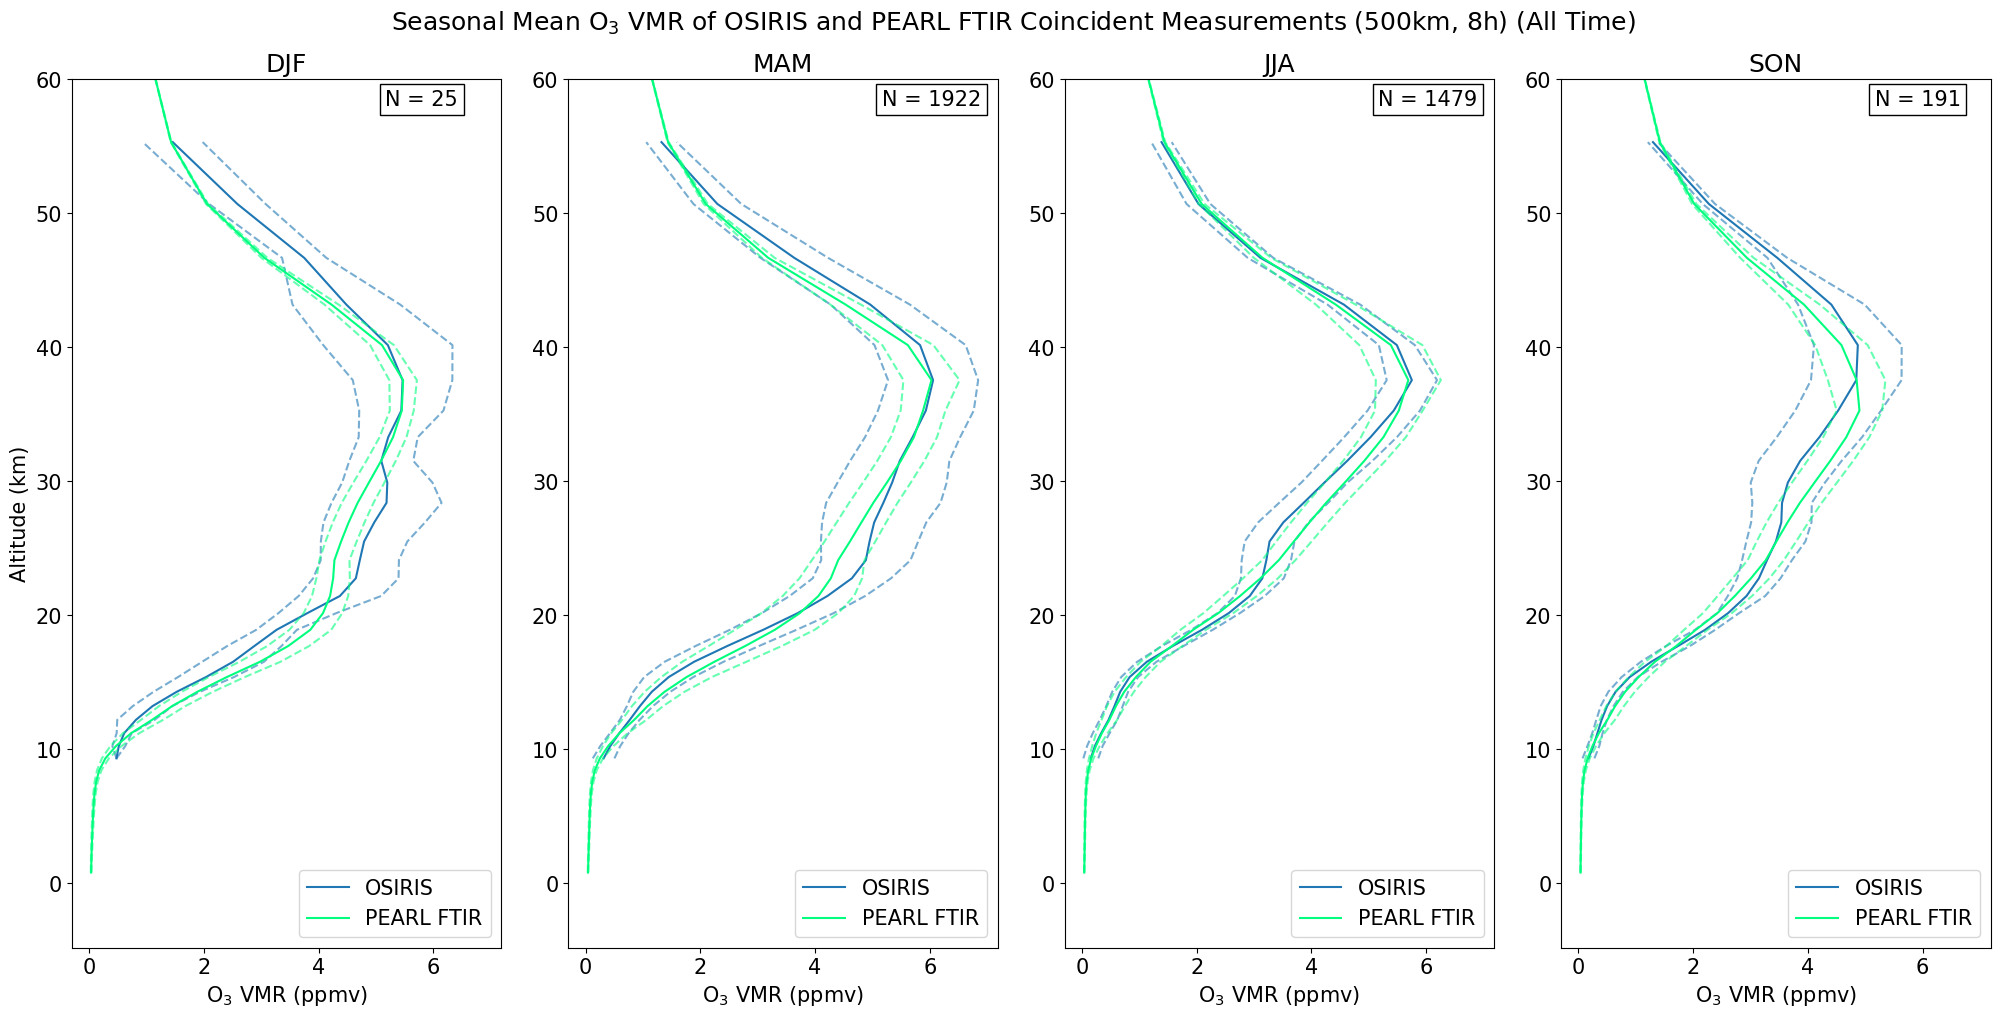

In [24]:
fig, axes = plt.subplots(1, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

xmins = []
xmaxs = []
ymins = []
ymaxs = []

for i, season in enumerate(seasons):
    ax = axes[i]
    n_season_coincidences = n_seasonal_coincidences[season]

    ax.plot(
        mean_O_seasonal[season] * 10**6,
        ALT_GRID,
        label = "OSIRIS", color = "C0"
    )

    ax.plot(
        (mean_O_seasonal[season] - std_O_seasonal[season]) * 10**6,
        ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6
    )

    ax.plot(
        (mean_O_seasonal[season] + std_O_seasonal[season]) * 10**6,
        ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6
    )


    ax.set_title(f"{season}")

    ax.plot(
        mean_P_seasonal[season] * 10**6,
        ALT_GRID,
        label = "PEARL FTIR", color = "springgreen"
    )

    ax.plot(
        (mean_P_seasonal[season] - std_P_seasonal[season]) * 10**6,
        ALT_GRID, color = "springgreen", linestyle = "dashed",  alpha = 0.6
    )

    ax.plot(
        (mean_P_seasonal[season] + std_P_seasonal[season]) * 10**6,
        ALT_GRID, color = "springgreen", linestyle = "dashed",  alpha = 0.6
    )

    ax.set_xlabel("O$_3$ VMR (ppmv)")
    
    ax.legend()

    ax.text(0.730, 0.970, f"N = {n_season_coincidences}", fontsize=15, transform=ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

    top_ax = ax
    top_ymin, top_ymax = top_ax.get_ylim()

    top_xmin, top_xmax = top_ax.get_xlim()

    xmins.append(top_xmin)
    xmaxs.append(top_xmax)

    ymins.append(top_ymin)
    ymaxs.append(top_ymax)

min_xlim, max_xlim = min(xmins), max(xmaxs)
min_ylim, max_ylim = min(ymins), min(ymaxs)

for ax in axes.flat:
    ax.set_xlim(min_xlim, max_xlim)
    ax.set_ylim(top = 60)
    
fig.tight_layout()

axes[0].set_ylabel("Altitude (km)")

plt.suptitle("Seasonal Mean O$_3$ VMR of OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")


C:\Users\salla\AppData\Local\Temp\ipykernel_23132\687232913.py:16: RuntimeWarning: invalid value encountered in divide
  O_standardized = (o3O_seasonal_coincidences[season] - mean_O_seasonal[season]) / std_O_seasonal[season]


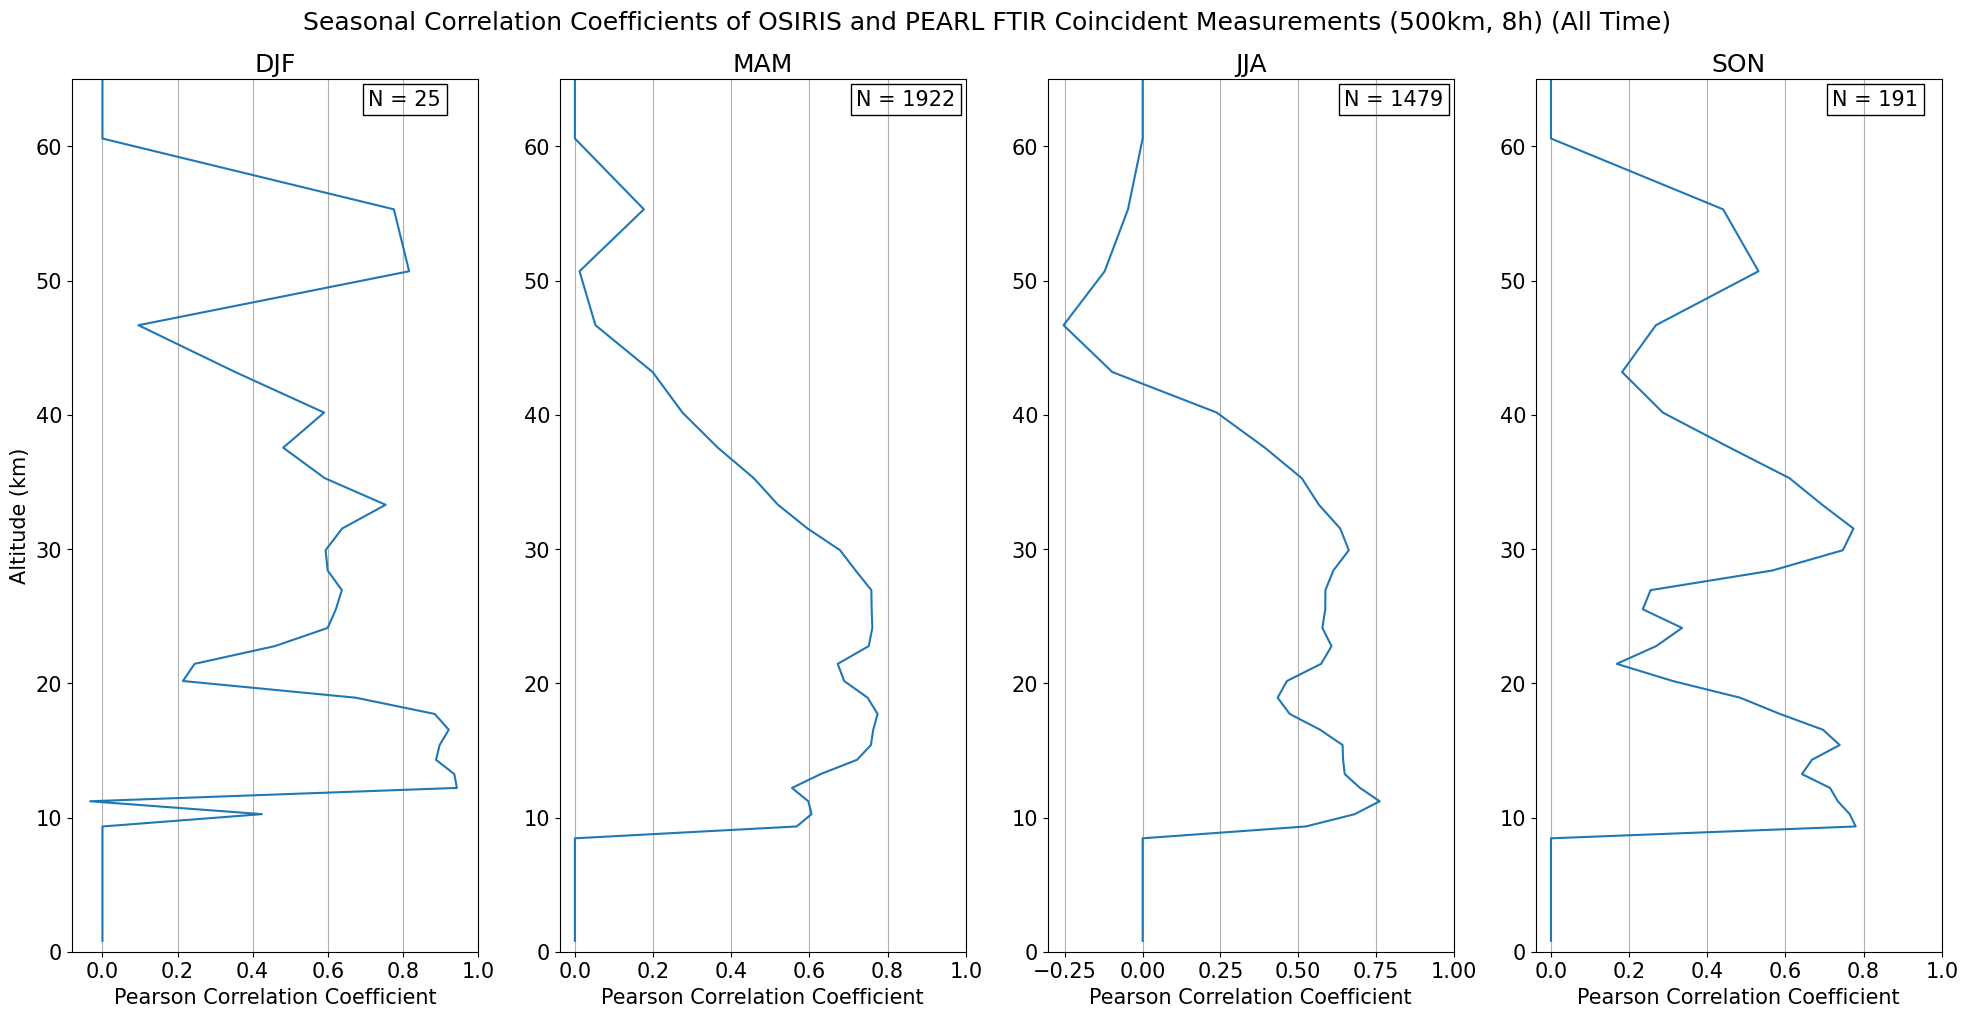

In [25]:
fig, axes = plt.subplots(1, len(n_seasonal_coincidences) - len(no_seasonal_coincidences), figsize=(20, 10))
seasons = list(seasonal_months.keys())

for season in no_seasonal_coincidences:
    seasons.remove(season)

r_seasonal = {}

xmins = []
xmaxs = []
ymins = []
ymaxs = []

for season in o3O_seasonal_coincidences:
   
    O_standardized = (o3O_seasonal_coincidences[season] - mean_O_seasonal[season]) / std_O_seasonal[season]
    P_standardized = (o3P_seasonal_coincidences[season] - mean_P_seasonal[season]) / std_P_seasonal[season]

    mask = ~np.isnan(O_standardized) & ~np.isnan(P_standardized)

    numerator = np.nansum(O_standardized * P_standardized, axis=0)
    valid_counts = np.sum(mask, axis=0)
    denominator = valid_counts - 1

    r = numerator / denominator
    r_seasonal[season] = r
    

for i, season in enumerate(seasons):
    ax = axes[i]
    n_season_coincidences = n_seasonal_coincidences[season]

    ax.plot(
        r_seasonal[season],
        ALT_GRID
    )


    ax.set_title(f"{season}")

    ax.set_xlabel("Pearson Correlation Coefficient")

    ax.text(0.730, 0.970, f"N = {n_season_coincidences}", fontsize=15, transform=ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

    top_ax = ax
    top_ymin, top_ymax = top_ax.get_ylim()

    top_xmin, top_xmax = top_ax.get_xlim()

    xmins.append(top_xmin)
    xmaxs.append(top_xmax)

    ymins.append(top_ymin)
    ymaxs.append(top_ymax)

min_xlim, max_xlim = min(xmins), max(xmaxs)
min_ylim, max_ylim = min(ymins), min(ymaxs)

for ax in axes.flat:
    ax.set_xlim(right = 1)
    ax.set_ylim(bottom = 0, top = 65)
    ax.grid(axis = "x")

axes[0].set_ylabel("Altitude (km)")

fig.tight_layout()

plt.suptitle("Seasonal Correlation Coefficients of OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", y = 1.02)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")



C:\Users\salla\AppData\Local\Temp\ipykernel_23132\1740132311.py:3: RuntimeWarning: Mean of empty slice
  mean_O = np.nanmean(o3O_coincidences, axis = 0)


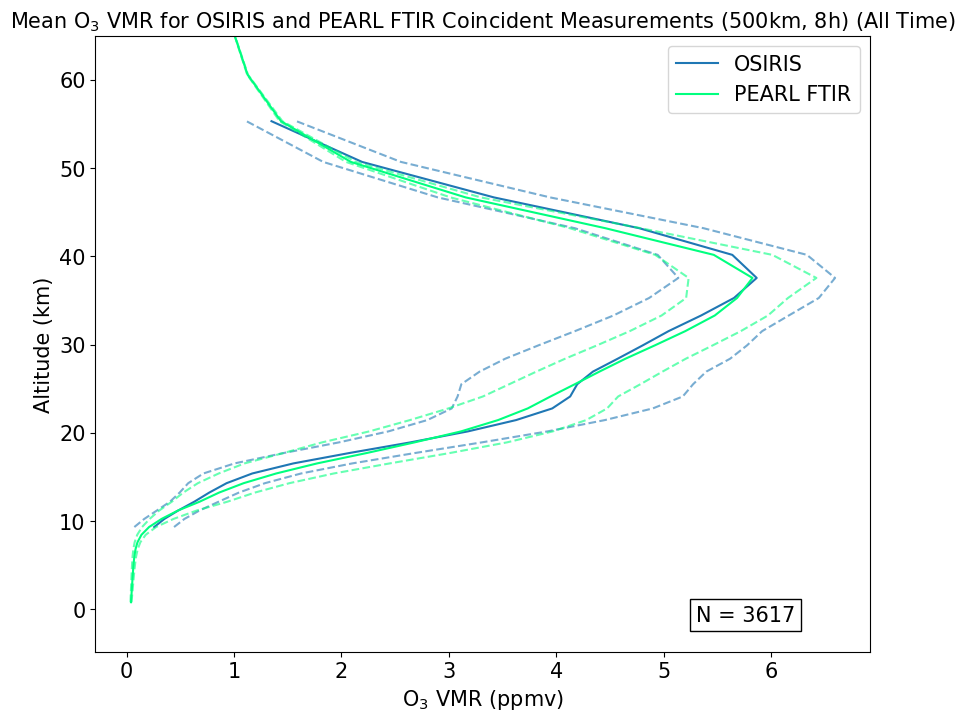

In [26]:
std_O = np.nanstd(o3O_coincidences, axis = 0)
std_P = np.nanstd(o3P_coincidences, axis = 0)
mean_O = np.nanmean(o3O_coincidences, axis = 0)
mean_P = np.nanmean(o3P_coincidences, axis = 0)

plt.figure(figsize=(10,8))
plt.plot(mean_O * 10**6, ALT_GRID, label = "OSIRIS")
plt.plot((mean_O - std_O) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot((mean_O + std_O) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)


plt.plot(mean_P * 10**6, ALT_GRID, label = "PEARL FTIR", color = "springgreen")
plt.plot((mean_P - std_P) * 10**6, ALT_GRID, color = "springgreen", linestyle = "dashed", alpha = 0.6)
plt.plot((mean_P + std_P) * 10**6, ALT_GRID, color = "springgreen", linestyle = "dashed", alpha = 0.6)

plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

axes.text(0.775, 0.050, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
axes.set_ylim(top = 65)

title = axes.get_title()
fig.savefig(title + "(OSIRIS and PEARL FTIR)", bbox_inches="tight")

In [27]:
o3O_std = np.nanstd(o3O_coincidences, axis = 0, ddof = 1)[None, :]
o3P_std = np.nanstd(o3P_coincidences, axis = 0, ddof = 1)[None, :]
o3O_mean = np.nanmean(o3O_coincidences, axis = 0)[None, :]
o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]

C:\Users\salla\AppData\Local\Temp\ipykernel_23132\3183882761.py:3: RuntimeWarning: Mean of empty slice
  o3O_mean = np.nanmean(o3O_coincidences, axis = 0)[None, :]


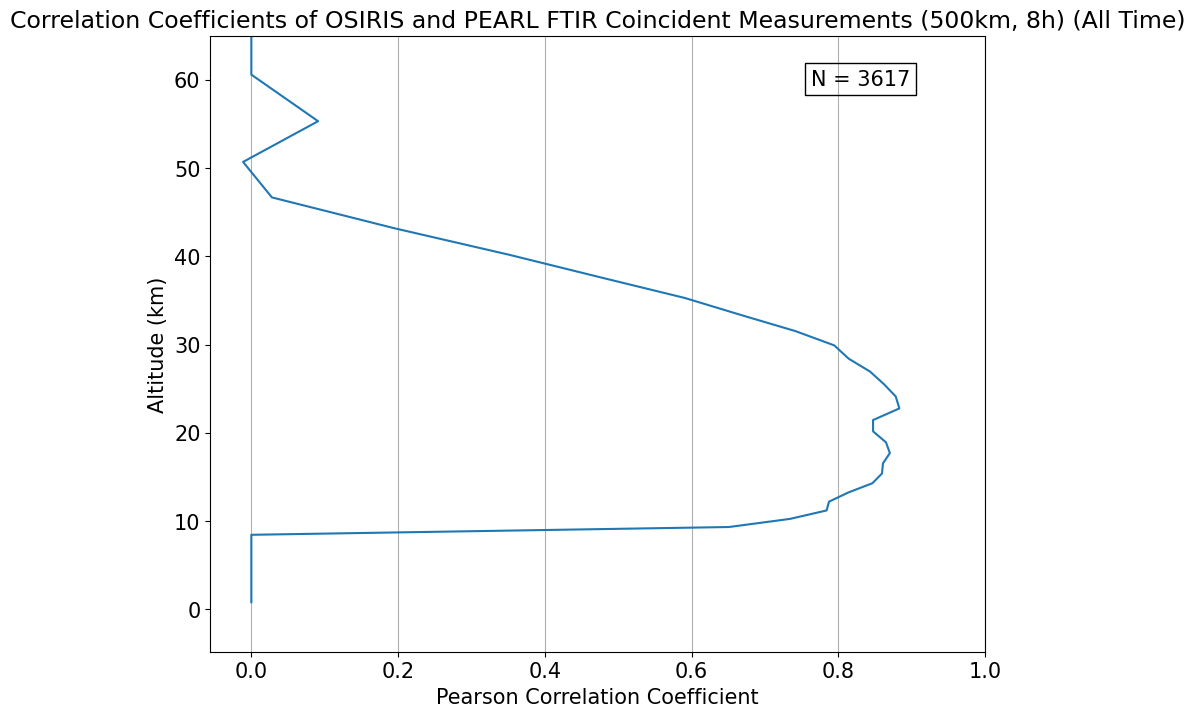

In [30]:
plt.figure(figsize=(10,8))
A_standardized = (o3O_coincidences - o3O_mean) / o3O_std
P_standardized = (o3P_coincidences - o3P_mean) / o3P_std

mask = ~np.isnan(A_standardized) & ~np.isnan(P_standardized)

numerator = np.nansum(A_standardized * P_standardized, axis=0)
valid_counts = np.sum(mask, axis=0)
denominator = valid_counts - 1

r = numerator / denominator

plt.plot(r, ALT_GRID)
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Correlation Coefficients of OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {"fontsize": 17})

fig = plt.gcf()
axes = plt.gca()

axes.grid(axis = "x")
axes.text(0.775, 0.920, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
axes.set_ylim(top = 65)
axes.set_xlim(right = 1)

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [29]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")